# Case study: Lorenz attractor
##### License: Apache 2.0


This notebook contains a full TDA pipeline to analyse the transitions of the Lorenz system to a chaotic regime from the stable one and viceversa.

The first step consists in importing the *giotto* library.

In [1]:
# Import the giotto library
import giotto as go
import giotto.time_series as ts
import giotto.graphs as gr
import giotto.diagrams as diag
import giotto.homology as hl
import numpy as np
import sklearn as sk
from giotto.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

import plotly.graph_objs as gobj
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# import data from openml
import openml

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotting functions

The *plotting.py* file is required to use the following plotting functions. It can be found in the *examples* folder on out github.

In [4]:
# Plotting functions
from plotting import plot_diagram, plot_landscapes
from plotting import plot_betti_surfaces, plot_betti_curves
from plotting import plot_point_cloud

# Setting up the Lorenz attractor simulation

In the next block we set up all the parameters of the Lorenz system and we define also the instants at which the regime (stable VS chaotic) changes.

In [5]:
# Plotting the trajectories of the Lorenz system
from openml.datasets.functions import get_dataset

point_cloud = get_dataset(42182).get_data(dataset_format='array')[0]
plot_point_cloud(point_cloud)

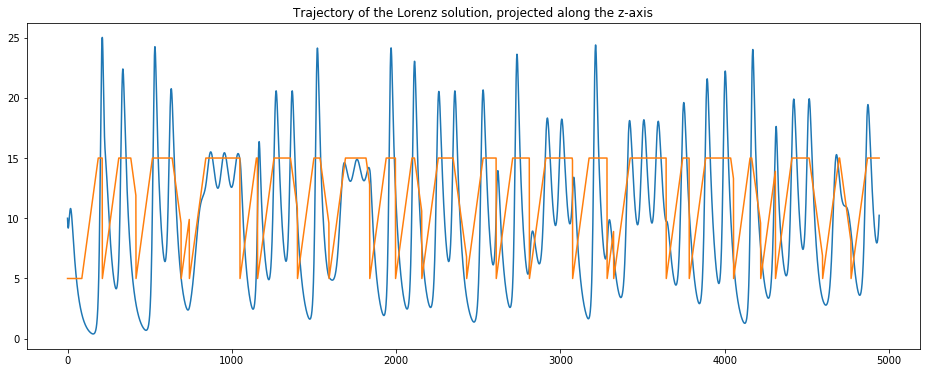

In [6]:
# Selecting the z-axis and the label rho
X = point_cloud[:,2].reshape(-1, 1)
y = point_cloud[:,3]

# Plotting the Lorenz system
fig = plt.figure(figsize=(16,6))
plt.plot(X)
plt.plot(y)
plt.title('Trajectory of the Lorenz solution, projected along the z-axis')
plt.show()

# Resampling the time series

It is important to find the correct time scale at which key signals take place. Here we propose one possible resampling period: *10h*. Recall that the unit time is *1h*. The resampler method is used to perform the resampling.

In [7]:
period = 10
periodicSampler = ts.Resampler(period=period)

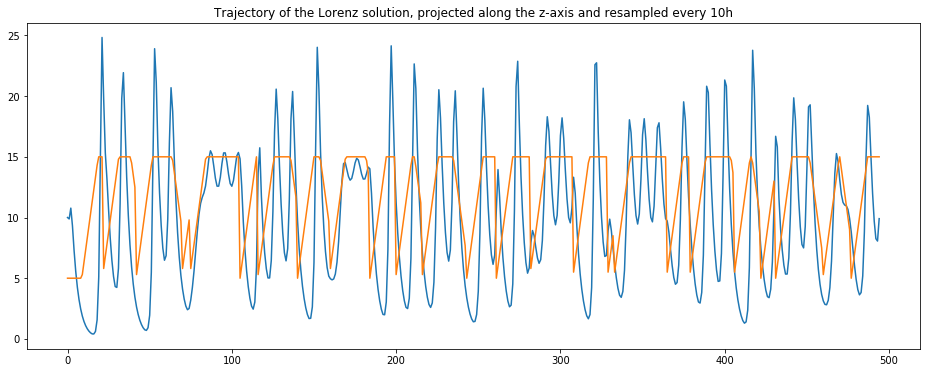

In [8]:
periodicSampler.fit(X)
X_sampled, y_sampled = periodicSampler.transform_resample(X, y)

fig = plt.figure(figsize=(16,6))
plt.plot(X_sampled)
plt.plot(y_sampled)
plt.title('Trajectory of the Lorenz solution, projected along the z-axis and resampled every 10h')
plt.show()

In [9]:
# Steps of the Pipeline
steps = [
    ('sampling', ts.Resampler(period=period)),
    ('regressor', RandomForestRegressor(n_estimators=100))
]

# Sklearn Pipeline
pipeline = Pipeline(steps)

pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('sampling', Resampler(period=10)),
                ('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

# Takens Embedding

In order to obtain meaningful topological features from a time series, we use a delayed-time embedding technique, invented by F. Takens in the late sixties.
The idea is simple: given a time series X(t), one can extract a sequence of vectors of the form X_i := [(X(t_i)), X(t_i + 2 tau), ..., X(t_i + M tau)].
The difference between t_i and t_i-1 is called *stride*; the numbers M and tau are optimized authomatically in this example (they can be set by the user if needed).
    
The *outer window* allows us to apply Takens embedding locally on a certain interval rather than over the whole time series. The result of this procedure is therefore a time series of point clouds with possibly interesting topologies.


In [10]:
embedding_dimension = 10
embedding_time_delay = 3
embedder = ts.TakensEmbedding(parameters_type='search', dimension=embedding_dimension, 
                             time_delay=embedding_time_delay, n_jobs=-1)

In [11]:
embedder.fit(X)
embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

print('Optimal embedding time delay based on mutual information: ', embedder_time_delay)
print('Optimal embedding dimension based on false nearest neighbors: ', embedder_dimension)

Optimal embedding time delay based on mutual information:  3
Optimal embedding dimension based on false nearest neighbors:  10


In [12]:
X_embedded, y_embedded = embedder.transform_resample(X_sampled, y_sampled)

In [13]:
window_width = 40
window_stride = 5
sliding_window = ts.SlidingWindow(width=window_width, stride=window_stride)
sliding_window.fit(X_embedded, y_embedded)

X_windows, y_windows = sliding_window.transform_resample(X_embedded, y_embedded)

In [14]:
# Plotting Takens embedding of the third outer window
window_number = 3
window = X_windows[window_number][:,:3]
plot_point_cloud(window)

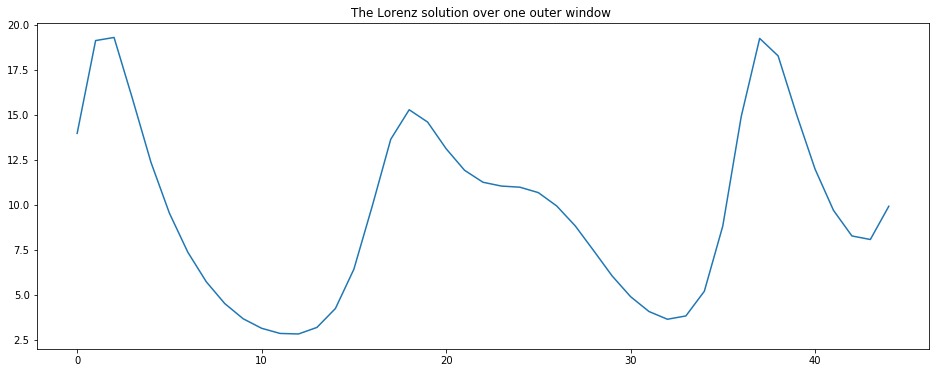

In [15]:
# Plotting the time series associated to the above point cloud. 
# Notice the two periodicities corresponding to the loops in the embedding
fig = plt.figure(figsize=(16,6))
plt.plot(X_sampled[(window_number*window_stride)*embedder_time_delay*embedder_dimension:
                   (window_number*window_stride + window_width)*embedder_time_delay*embedder_dimension])
plt.title('The Lorenz solution over one outer window ')
plt.show()

# Persistence diagram
The topological information of the correlation metric is synthesised in the persistent diagram. The horizonral axis corresponds to the moment in which an homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.
The generators of the homology groups (at given rank) are colored differently.

In [33]:
homology_dimensions = [0, 1, 2, 3]
persistenceDiagram = hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=100, 
                                            homology_dimensions=homology_dimensions, n_jobs=1)
persistenceDiagram.fit(X_windows)
X_diagrams = persistenceDiagram.transform(X_windows, y_windows)

Are you a Machine Learning enthusiast? Come check the new EPFL Extension School:  https://exts.epfl.ch/                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [21]:
for i in range(10):
    print('hello', end='\r')

In [17]:
# Plot the persistence diagram
plot_diagram(X_diagrams[window_number])

# Scikit-learn *Pipeline*
One of the advantages of our giotto library is the compatibility with scikit-learn. It is possible to set up a full pipeline such as the one above in a few lines. We will show how in the next section.



In [ ]:
# Steps of the Pipeline
steps = [
    ('sampling', ts.Resampler(period=period)),
    ('embedding', ts.TakensEmbedding(parameters_type='search', dimension=embedding_dimension, 
                                    time_delay=embedding_time_delay, n_jobs=-1)),
    ('window', ts.SlidingWindow(width=window_width, stride=window_stride)),
    ('diagrams', hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=100, 
                                            homology_dimensions=homology_dimensions, n_jobs=-1))
]

# Sklearn Pipeline
pipeline = Pipeline(steps)

In [ ]:
# Running the pipeline
pipeline.fit(X)
X_diagrams = pipeline.transform(X)

In [ ]:
# Plotting the final persistent diagram of one outer window
plot_diagram(X_diagrams[window_number])

# Rescaling the diagram
Rescaling the diagram means normalizing the points such that their distance from the *empty diagram* is equal to one.
Once the diagram is rescaled, we can filter noise by removing all the points that are close to the diagonal.

In [ ]:
diagram_scaler = diag.Scaler()
diagram_scaler.fit(X_diagrams)
X_scaled = diagram_scaler.transform(X_diagrams)

plot_diagram(X_scaled[window_number])

# Filtering diagrams

Filtering noise from a diagram corresponds to eliminating all the homology generators whose lifespan is too short to be significant. It means equivalently that we are removing the points closer to the diagonal than a centrain threshold.

In [ ]:
# Perparing the filtering transformer
diagram_filter = diag.Filtering(epsilon=0.1, homology_dimensions=[1, 2])
diagram_filter.fit(X_scaled)
X_filtered = diagram_filter.transform(X_scaled)

In [ ]:
plot_diagram(X_filtered[window_number])

In [ ]:
# Wrapping up all the steps inside a scikit-learn pipeline
steps = [
    ('sampling', ts.Resampler(period=period)),
    ('embedding', ts.TakensEmbedding(parameters_type='search', dimension=embedding_dimension, 
                                    time_delay=embedding_time_delay, n_jobs=1)),
    ('window', ts.SlidingWindow(width=window_width, stride=window_stride)),
    ('diagrams', hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=100, 
                                            homology_dimensions=homology_dimensions, n_jobs=1)),
    ('diagrams_scaler', diag.Scaler()),
    ('diagrams_filter', diag.Filtering(epsilon=0.1))
]

pipeline_filter = Pipeline(steps)

In [ ]:
pipeline_filter.fit(X)
X_filtered_noisy = pipeline_filter.transform(X)

In [ ]:
plot_diagram(X_filtered_noisy[window_number])

# Persistence entropy

In this section we show how to compute the entropy of persistence diagrams.

In [ ]:
# Perparing the filtering transformer
persistent_entropy = diag.PersistenceEntropy()
persistent_entropy.fit(X_scaled)
X_persistent_entropy = persistent_entropy.transform(X_scaled)

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.plot(X_persistent_entropy)
plt.title('Trajectory of the Lorenz solution, projected along the z-axis')
plt.show()

# Betti Curves
In this section we show how to compute the Betti curves of a persistent diagram. We also show the plot of the Betti surface, i.e. the time-stack of the bettu curves.

In [ ]:
betti_curves = diag.BettiCurve()
betti_curves.fit(X_scaled)
X_betti_curves = betti_curves.transform(X_scaled)

In [ ]:
plot_betti_curves(X_betti_curves[window_number])

In [ ]:
plot_betti_surfaces(X_betti_curves)

# Distances among diagrams

In this section we show how to compute distances among persistent diagrams. There are many notions of distances: here we use the *bottleneck distance* as an example.

We stress that the *i-th* row of this matrix is the distance of the *i-th* diagram from all the others.

In [ ]:
# We change metric: we compute the landscape distance among the diagrams 
diagram_distance = diag.PairwiseDistance(metric='landscape', metric_params={'p': 2, 'n_layers':1, 'n_values':1000}, 
                                       order=None, n_jobs=2)
diagram_distance.fit(X_diagrams)
X_distance_L = diagram_distance.transform(X_diagrams)

In [ ]:
# Plot of the landascape L2 distance between persistent diagrams 
figure = plt.figure(figsize=(10,10))
plt.imshow(X_distance_L[:,:, 0])
plt.colorbar()
plt.title('Landscape L2 distance matrix for H0')
plt.show()

In [ ]:
# We change metric: we compute the wasserestein distance among the diagrams 
diagram_distance = diag.PairwiseDistance(metric='wasserstein', metric_params={'p': 2, 'delta':0.2}, 
                                       order=2, n_jobs=1)
diagram_distance.fit(X_diagrams)
X_distance_W = diagram_distance.transform(X_diagrams)

In [ ]:
# Plot of the landascape L2 distance between persistent diagrams 
figure = plt.figure(figsize=(10,10))
plt.imshow(X_distance_W)
plt.colorbar()
plt.title('2-norm of 2-wassertein distance matrices')
plt.show()

# New distance in the embedding space: permutations and graphs

We propose here a new way to compute distances between points in the embedding space. Instead of considering the Euclidean distance in the Takens space, we propose to build a k-nearest neightbors graph and then use the geodesic distance on such graph.

In [ ]:
kNN_graph = gr.KNeighborsGraph(n_neighbors=3, n_jobs=1)
kNN_graph.fit(X_embedded)
X_kNN = kNN_graph.transform(X_embedded[0].reshape((1, X_embedded.shape[1], -1)))

# Geodesic distance on graphs
Given the graph embedding, the natural notion of distance between vertices corresponds to the lengths of the shortest path connecting two vertices. This is also known as *graph geodesic distance*. 

In [ ]:
geodesic_distance = gr.GraphGeodesicDistance(n_jobs=1)
geodesic_distance.fit(X_kNN)
X_GeoNN = geodesic_distance.transform(X_kNN)

In [ ]:
# Plotting the geodesic distance
figure = plt.figure(figsize=(10,10))
plt.imshow(X_GeoNN[0])
plt.colorbar()
plt.title('Plot of the geodesic distance of the first outer window kNN graph')
plt.show()

# Synthetic features extracted from topology

One can use persistent diagrams as he pleases. Here we show one way of extracting summary information from the time-series of diagrams: the *permutation entropy*. The entropy is computed by estimating a probability based on teh counting how many permutation patterns appear along the time series within the outer window.

In [ ]:
# Computing permutation entropy
permutation_entropy = ts.PermutationEntropy(n_jobs=1)
permutation_entropy.fit(X_windows)
X_entropy = permutation_entropy.transform(X_windows)

In [ ]:
# Plot the sampled Lorenz solution, projected along the z-axis
fig = plt.figure(figsize=(16,6))
plt.plot(X_sampled)
plt.title('Resampled solution of the Lorenz attractor projected along the z-axis')
plt.show()

In [ ]:
# Plot of the permutation entropy time-series
fig = plt.figure(figsize=(16,6))
plt.plot(X_entropy)
plt.title('Permutation entropy')
plt.show()